## Setup
As part of the setup you have already created an Azure ML Workspace object. For AutoML you will need to create an Experiment object, which is a named object in a Workspace used to run experiments.

In [2]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
import azureml.dataprep as dprep
from azureml.train.automl import AutoMLConfig

W0713 15:33:35.705439 140217527224064 deprecation_wrapper.py:119] From /data/anaconda/envs/py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.set_verbosity is deprecated. Please use tf.compat.v1.logging.set_verbosity instead.

W0713 15:33:35.706627 140217527224064 deprecation_wrapper.py:119] From /data/anaconda/envs/py36/lib/python3.6/site-packages/azureml/automl/core/_vendor/automl/client/core/common/tf_wrappers.py:36: The name tf.logging.ERROR is deprecated. Please use tf.compat.v1.logging.ERROR instead.



In [3]:
ws = Workspace.from_config()

# Choose a name for the experiment and specify the project folder.
experiment_name = 'automl-carprice-regression'
project_folder = './sample_projects/automl-carprice-regression'

experiment = Experiment(ws, experiment_name)

output = {}
output['SDK version'] = azureml.core.VERSION
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
SDK version,1.0.48
Subscription ID,0edc157c-d352-41a0-9ba0-886cb162b71f
Workspace Name,getready
Resource Group,ready2019
Location,westus2
Project Directory,./sample_projects/automl-carprice-regression
Experiment Name,automl-carprice-regression


## Create or Attach existing AmlCompute
You will need to create a compute target for your AutoML run. In this tutorial, you create AmlCompute as your training compute resource.
#### Creation of AmlCompute takes approximately 5 minutes. 
If the AmlCompute with that name is already in your workspace this code will skip the creation process.
As with other Azure services, there are limits on certain resources (e.g. AmlCompute) associated with the Azure Machine Learning service. Please read this article on the default limits and how to request more quota.

In [4]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget

# Choose a name for your cluster.
amlcompute_cluster_name = "automlcl"

found = False
# Check if this compute target already exists in the workspace.
cts = ws.compute_targets
if amlcompute_cluster_name in cts and cts[amlcompute_cluster_name].type == 'AmlCompute':
    found = True
    print('Found existing compute target.')
    compute_target = cts[amlcompute_cluster_name]
    
if not found:
    print('Creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size = "STANDARD_D2_V2", # for GPU, use "STANDARD_NC6"
                                                                #vm_priority = 'lowpriority', # optional
                                                                max_nodes = 6)

    # Create the cluster.
    compute_target = ComputeTarget.create(ws, amlcompute_cluster_name, provisioning_config)
    
    # Can poll for a minimum number of nodes and for a specific timeout.
    # If no min_node_count is provided, it will use the scale settings for the cluster.
    compute_target.wait_for_completion(show_output = True, min_node_count = None, timeout_in_minutes = 20)
    
     # For a more detailed view of current AmlCompute status, use get_status().

Found existing compute target.


## Data
This uses scikit-learn's [carprice.csv](https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/carprice.csv) method.

In [5]:
# You can use `auto_read_file` which intelligently figures out delimiters and datatypes of a file.
# The data referenced here is copied into a local temporary directory.
# You can also use `read_csv` and `to_*` transformations to read (with overridable delimiter)
# and convert column types manually.
example_data = 'https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/carprice.csv'
dflow = dprep.auto_read_file(example_data).skip(1)  # Remove the header row.
dflow.get_profile()

,Type,Min,Max,Count,Missing Count,Not Missing Count,Percent Missing,Error Count,Empty Count,Unique Values,0.1% Quantile (est.),1% Quantile (est.),5% Quantile (est.),25% Quantile (est.),50% Quantile (est.),75% Quantile (est.),95% Quantile (est.),99% Quantile (est.),99.9% Quantile (est.),Mean,Standard Deviation,Variance,Skewness,Kurtosis,WhiskerTop,WhiskerBottom
symboling,FieldType.INTEGER,-2.00,3.00,204.00,0.00,204.00,0.00,0.00,0.00,6,-2.00,-1.00,-1.00,0.00,1.00,2.00,3.00,3.00,3.00,0.82,1.24,1.54,0.21,-0.69,3.00,-2.00
normalized-losses,FieldType.STRING,101,?,204.00,0.00,204.00,0.00,0.00,0.00,52,,,,,,,,,,,,,,,,
make,FieldType.STRING,alfa-romero,volvo,204.00,0.00,204.00,0.00,0.00,0.00,22,,,,,,,,,,,,,,,,
fuel-type,FieldType.STRING,diesel,gas,204.00,0.00,204.00,0.00,0.00,0.00,2,,,,,,,,,,,,,,,,
aspiration,FieldType.STRING,std,turbo,204.00,0.00,204.00,0.00,0.00,0.00,2,,,,,,,,,,,,,,,,
num-of-doors,FieldType.STRING,?,two,204.00,0.00,204.00,0.00,0.00,0.00,3,,,,,,,,,,,,,,,,
body-style,FieldType.STRING,convertible,wagon,204.00,0.00,204.00,0.00,0.00,0.00,5,,,,,,,,,,,,,,,,
drive-wheels,FieldType.STRING,4wd,rwd,204.00,0.00,204.00,0.00,0.00,0.00,3,,,,,,,,,,,,,,,,
engine-location,FieldType.STRING,front,rear,204.00,0.00,204.00,0.00,0.00,0.00,2,,,,,,,,,,,,,,,,
wheel-base,FieldType.DECIMAL,86.60,120.90,204.00,0.00,204.00,0.00,0.00,0.00,53,86.60,93.70,93.70,94.50,96.98,102.40,110.60,115.60,120.90,98.81,5.99,35.93,1.05,0.94,114.20,86.60


In [24]:
# As `price` is our y data, we need to drop the values those are errors in this column and 4 others.
dflow = dflow.to_number(['price', 'bore', 'stroke', 'horsepower', 'peak-rpm'])
dflow = dflow.drop_errors('price')
dflow.head(5)

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111.00,5000.00,21,27,16500.00
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.50,...,152,mpfi,2.68,3.47,9.00,154.00,5000.00,19,26,16500.00
2,2,164,audi,gas,std,four,sedan,fwd,front,99.80,...,109,mpfi,3.19,3.40,10.00,102.00,5500.00,24,30,13950.00
3,2,164,audi,gas,std,four,sedan,4wd,front,99.40,...,136,mpfi,3.19,3.40,8.00,115.00,5500.00,18,22,17450.00
4,2,?,audi,gas,std,two,sedan,fwd,front,99.80,...,136,mpfi,3.19,3.40,8.50,110.00,5500.00,19,25,15250.00


In [25]:
dflow.dtypes

symboling                FieldType.INTEGER
normalized-losses        FieldType.STRING
make                     FieldType.STRING
fuel-type                FieldType.STRING
aspiration               FieldType.STRING
num-of-doors             FieldType.STRING
body-style               FieldType.STRING
drive-wheels             FieldType.STRING
engine-location          FieldType.STRING
wheel-base               FieldType.DECIMAL
length                   FieldType.DECIMAL
width                    FieldType.DECIMAL
height                   FieldType.DECIMAL
curb-weight              FieldType.INTEGER
engine-type              FieldType.STRING
num-of-cylinders         FieldType.STRING
engine-size              FieldType.INTEGER
fuel-system              FieldType.STRING
bore                     FieldType.DECIMAL
stroke                   FieldType.DECIMAL
compression-ratio        FieldType.DECIMAL
horsepower               FieldType.DECIMAL
peak-rpm                 FieldType.DECIMAL
city-mpg              

In [26]:
dflow.get_profile()

,Type,Min,Max,Count,Missing Count,Not Missing Count,Percent Missing,Error Count,Empty Count,Unique Values,0.1% Quantile (est.),1% Quantile (est.),5% Quantile (est.),25% Quantile (est.),50% Quantile (est.),75% Quantile (est.),95% Quantile (est.),99% Quantile (est.),99.9% Quantile (est.),Mean,Standard Deviation,Variance,Skewness,Kurtosis,WhiskerTop,WhiskerBottom
symboling,FieldType.INTEGER,-2.00,3.00,200.00,0.00,200.00,0.00,0.00,0.00,6,-2.00,-1.00,-1.00,0.00,1.00,2.00,3.00,3.00,3.00,0.83,1.25,1.56,0.20,-0.72,3.00,-2.00
normalized-losses,FieldType.STRING,101,?,200.00,0.00,200.00,0.00,0.00,0.00,52,,,,,,,,,,,,,,,,
make,FieldType.STRING,alfa-romero,volvo,200.00,0.00,200.00,0.00,0.00,0.00,22,,,,,,,,,,,,,,,,
fuel-type,FieldType.STRING,diesel,gas,200.00,0.00,200.00,0.00,0.00,0.00,2,,,,,,,,,,,,,,,,
aspiration,FieldType.STRING,std,turbo,200.00,0.00,200.00,0.00,0.00,0.00,2,,,,,,,,,,,,,,,,
num-of-doors,FieldType.STRING,?,two,200.00,0.00,200.00,0.00,0.00,0.00,3,,,,,,,,,,,,,,,,
body-style,FieldType.STRING,convertible,wagon,200.00,0.00,200.00,0.00,0.00,0.00,5,,,,,,,,,,,,,,,,
drive-wheels,FieldType.STRING,4wd,rwd,200.00,0.00,200.00,0.00,0.00,0.00,3,,,,,,,,,,,,,,,,
engine-location,FieldType.STRING,front,rear,200.00,0.00,200.00,0.00,0.00,0.00,2,,,,,,,,,,,,,,,,
wheel-base,FieldType.DECIMAL,86.60,120.90,200.00,0.00,200.00,0.00,0.00,0.00,52,86.60,93.70,93.70,94.50,96.98,102.40,111.00,115.60,120.90,98.85,6.04,36.46,1.03,0.87,114.20,86.60


In [27]:
#data = "https://automlsamplenotebookdata.blob.core.windows.net/automl-sample-notebook-data/carprice.csv"
#dflow = dprep.auto_read_file(data)
dflow.get_profile()
X = dflow.drop_columns(columns=['symboling','normalized-losses','price'])
y = dflow.keep_columns(columns=['price'], validate_column_exists=True)
X_train, X_test = X.random_split(percentage=0.8, seed=223)
y_train, y_test = y.random_split(percentage=0.8, seed=223) 
dflow.head()

,symboling,normalized-losses,make,fuel-type,aspiration,num-of-doors,body-style,drive-wheels,engine-location,wheel-base,...,engine-size,fuel-system,bore,stroke,compression-ratio,horsepower,peak-rpm,city-mpg,highway-mpg,price
0,3,?,alfa-romero,gas,std,two,convertible,rwd,front,88.60,...,130,mpfi,3.47,2.68,9.00,111.00,5000.00,21,27,16500.00
1,1,?,alfa-romero,gas,std,two,hatchback,rwd,front,94.50,...,152,mpfi,2.68,3.47,9.00,154.00,5000.00,19,26,16500.00
2,2,164,audi,gas,std,four,sedan,fwd,front,99.80,...,109,mpfi,3.19,3.40,10.00,102.00,5500.00,24,30,13950.00
3,2,164,audi,gas,std,four,sedan,4wd,front,99.40,...,136,mpfi,3.19,3.40,8.00,115.00,5500.00,18,22,17450.00
4,2,?,audi,gas,std,two,sedan,fwd,front,99.80,...,136,mpfi,3.19,3.40,8.50,110.00,5500.00,19,25,15250.00
5,1,158,audi,gas,std,four,sedan,fwd,front,105.80,...,136,mpfi,3.19,3.40,8.50,110.00,5500.00,19,25,17710.00
6,1,?,audi,gas,std,four,wagon,fwd,front,105.80,...,136,mpfi,3.19,3.40,8.50,110.00,5500.00,19,25,18920.00
7,1,158,audi,gas,turbo,four,sedan,fwd,front,105.80,...,131,mpfi,3.13,3.40,8.30,140.00,5500.00,17,20,23875.00
8,2,192,bmw,gas,std,two,sedan,rwd,front,101.20,...,108,mpfi,3.50,2.80,8.80,101.00,5800.00,23,29,16430.00
9,0,192,bmw,gas,std,four,sedan,rwd,front,101.20,...,108,mpfi,3.50,2.80,8.80,101.00,5800.00,23,29,16925.00


In [28]:
from azureml.core.runconfig import RunConfiguration
from azureml.core.conda_dependencies import CondaDependencies

# create a new RunConfig object
conda_run_config = RunConfiguration(framework="python")

# Set compute target to AmlCompute
conda_run_config.target = compute_target
conda_run_config.environment.docker.enabled = True
conda_run_config.environment.docker.base_image = azureml.core.runconfig.DEFAULT_CPU_IMAGE


cd = CondaDependencies.create(pip_packages=['azureml-sdk[automl]'], conda_packages=['numpy'])
conda_run_config.environment.python.conda_dependencies = cd

## Train

Instantiate an `AutoMLConfig` object to specify the settings and data used to run the experiment.

|Property|Description|
|-|-|
|**task**|classification or regression|
|**primary_metric**|This is the metric that you want to optimize. Regression supports the following primary metrics: <br><i>spearman_correlation</i><br><i>normalized_root_mean_squared_error</i><br><i>r2_score</i><br><i>normalized_mean_absolute_error</i>|
|**iteration_timeout_minutes**|Time limit in minutes for each iteration.|
|**iterations**|Number of iterations. In each iteration AutoML trains a specific pipeline with the data.|
|**n_cross_validations**|Number of cross validation splits.|
|**X**|(sparse) array-like, shape = [n_samples, n_features]|
|**y**|(sparse) array-like, shape = [n_samples, ], targets values.|
|**path**|Relative path to the project folder. AutoML stores configuration files for the experiment under this folder. You can specify a new empty folder.|

**_You can find more information about primary metrics_** [here](https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-configure-auto-train#primary-metric)
                                                            

In [29]:
automl_settings = {
    "iteration_timeout_minutes": 5,
    "iterations": 10,
    "n_cross_validations": 5,
    "primary_metric": 'spearman_correlation',
    "preprocess": True,
    "max_concurrent_iterations": 5,
    "verbosity": logging.INFO,
}

automl_config = AutoMLConfig(task = 'regression',
                             debug_log = 'automl.log',
                             path = project_folder,
                             run_configuration=conda_run_config,
                             X = X_train,
                             y = y_train,
                             **automl_settings
                            )

In [30]:
remote_run = experiment.submit(automl_config, show_output = True)

Running on remote compute: automlcl
Parent Run ID: AutoML_b3e6890e-c49e-4ec4-bb84-e4a7c0537fcb
Current status: ModelSelection. Beginning model selection.

****************************************************************************************************
ITERATION: The iteration being evaluated.
PIPELINE: A summary description of the pipeline being evaluated.
DURATION: Time taken for the current iteration.
METRIC: The result of computing score on the fitted pipeline.
BEST: The best observed score thus far.
****************************************************************************************************

 ITERATION   PIPELINE                                       DURATION      METRIC      BEST
         0   StandardScalerWrapper RandomForest             0:00:52       0.9151    0.9151
         2   StandardScalerWrapper ExtremeRandomTrees       0:01:30       0.8852    0.9151
         3   StandardScalerWrapper LightGBM                 0:02:09       0.9072    0.9151
         4   Standard

In [31]:
remote_run

Experiment,Id,Type,Status,Details Page,Docs Page
automl-carprice-regression,AutoML_b3e6890e-c49e-4ec4-bb84-e4a7c0537fcb,automl,Completed,Link to Azure Portal,Link to Documentation


## Results
Widget for Monitoring Runs
The widget will first report a â€œloading status while running the first iteration. After completing the first iteration, an auto-updating graph and table will be shown. The widget will refresh once per minute, so you should see the graph update as child runs complete.
Note: The widget displays a link at the bottom. Use this link to open a web interface to explore the individual run details.

In [32]:
from azureml.widgets import RunDetails
RunDetails(remote_run).show()

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

Retrieve All Child Runs
You can also use SDK methods to fetch all the child runs and see individual metrics that we log.

In [33]:
children = list(remote_run.get_children())
metricslist = {}
for run in children:
    properties = run.get_properties()
    metrics = {k: v for k, v in run.get_metrics().items() if isinstance(v, float)}
    metricslist[int(properties['iteration'])] = metrics

rundata = pd.DataFrame(metricslist).sort_index(1)
rundata

,0,1,2,3,4,5,6,7,8,9
explained_variance,0.74,0.86,0.78,0.78,0.84,0.84,0.83,0.82,0.86,0.84
mean_absolute_error,2230.05,1732.39,2127.87,1913.49,1877.21,1763.76,1804.03,1913.20,1675.55,1793.87
mean_absolute_percentage_error,15.22,12.34,15.55,13.98,13.21,13.09,13.61,14.10,12.19,12.60
median_absolute_error,1095.57,1048.20,1202.72,1180.30,979.83,1153.44,1075.62,987.60,1002.79,1013.76
normalized_mean_absolute_error,0.06,0.04,0.05,0.05,0.05,0.04,0.04,0.05,0.04,0.04
normalized_median_absolute_error,0.03,0.03,0.03,0.03,0.02,0.03,0.03,0.02,0.02,0.03
normalized_root_mean_squared_error,0.09,0.06,0.08,0.07,0.07,0.07,0.07,0.07,0.06,0.07
normalized_root_mean_squared_log_error,0.09,0.07,0.09,0.08,0.08,0.08,0.08,0.09,0.07,0.07
r2_score,0.73,0.85,0.77,0.78,0.83,0.84,0.83,0.82,0.86,0.84
root_mean_squared_error,3610.97,2485.93,3253.44,2956.40,2868.92,2708.39,2750.36,2882.98,2487.16,2687.51


## Retrieve the Best Model
Below we select the best pipeline from our iterations. The get_output method returns the best run and the fitted model. The Model includes the pipeline and any pre-processing. Overloads on get_output allow you to retrieve the best run and fitted model for any logged metric or for a particular iteration.

In [38]:
best_run, fitted_model = remote_run.get_output()
print(best_run)
print(fitted_model)

W0713 17:24:06.051328 140217527224064 package_utilities.py:102] The version of the SDK does not match the version the model was trained on.
W0713 17:24:06.052364 140217527224064 package_utilities.py:103] The consistency in the result may not be guaranteed.
W0713 17:24:06.052933 140217527224064 package_utilities.py:108] Package:azureml-dataprep, training version:1.1.8, current version:1.1.7
W0713 17:24:06.053475 140217527224064 run.py:510] Please ensure the version of your local conda dependencies match the version on which your model was trained in order to properly retrieve your model. 

Try running `pip install --upgrade azureml-sdk[automl]==1.0.48`




Run(Experiment: automl-carprice-regression,
Id: AutoML_b3e6890e-c49e-4ec4-bb84-e4a7c0537fcb_8,
Type: azureml.scriptrun,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('prefittedsoftvotingregressor', PreFittedSoftVotingRegressor(estimators=[('1', Pipeline(memory=None,
     steps=[('maxabs...))],
               flatten_transform=None,
               weights=[0.5, 0.1, 0.1, 0.1, 0.1, 0.1]))]),
          stddev=None)


Best Model Based on Any Other Metric Show the run and the model that has the smallest root_mean_squared_error value (which turned out to be the same as the one with largest spearman_correlation value):

In [35]:
lookup_metric = "root_mean_squared_error"
best_run, fitted_model = remote_run.get_output(metric = lookup_metric)
print(best_run)
print(fitted_model)

W0713 17:17:39.043850 140217527224064 package_utilities.py:102] The version of the SDK does not match the version the model was trained on.
W0713 17:17:39.044802 140217527224064 package_utilities.py:103] The consistency in the result may not be guaranteed.
W0713 17:17:39.045540 140217527224064 package_utilities.py:108] Package:azureml-dataprep, training version:1.1.8, current version:1.1.7
W0713 17:17:39.046173 140217527224064 run.py:510] Please ensure the version of your local conda dependencies match the version on which your model was trained in order to properly retrieve your model. 

Try running `pip install --upgrade azureml-sdk[automl]==1.0.48`




Run(Experiment: automl-carprice-regression,
Id: AutoML_b3e6890e-c49e-4ec4-bb84-e4a7c0537fcb_1,
Type: azureml.scriptrun,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('MaxAbsScaler', MaxAbsScaler(copy=True)), ('RandomForestRegressor', RandomForestRegressor(bootstrap=True, criterion='mse'...timators=25, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False))]),
          stddev=None)


In [36]:
iteration = 3
third_run, third_model = remote_run.get_output(iteration = iteration)
print(third_run)
print(third_model)

W0713 17:18:05.487207 140217527224064 package_utilities.py:102] The version of the SDK does not match the version the model was trained on.
W0713 17:18:05.488077 140217527224064 package_utilities.py:103] The consistency in the result may not be guaranteed.
W0713 17:18:05.488736 140217527224064 package_utilities.py:108] Package:azureml-dataprep, training version:1.1.8, current version:1.1.7
W0713 17:18:05.489274 140217527224064 run.py:510] Please ensure the version of your local conda dependencies match the version on which your model was trained in order to properly retrieve your model. 

Try running `pip install --upgrade azureml-sdk[automl]==1.0.48`




Run(Experiment: automl-carprice-regression,
Id: AutoML_b3e6890e-c49e-4ec4-bb84-e4a7c0537fcb_3,
Type: azureml.scriptrun,
Status: Completed)
RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_feature_sweeping=None, feature_sweeping_timeout=None,
        is_onnx_compatible=None, logger=None, observer=None, task=None)), ('StandardScalerWrapper', <automl.client.core.common.model_wrappers.StandardScalerWrapper object at 0x7f865011ce10>), ('Li...nt=True,
         subsample=0.65, subsample_for_bin=200000, subsample_freq=1,
         verbose=-1))]),
          stddev=None)


## Register the Fitted Model for Deployment
If neither metric nor iteration are specified in the register_model call, the iteration with the best primary metric is registered.

In [39]:
description = 'AutoML Model'
tags = None
model = remote_run.register_model(description = description, tags = tags)

print(remote_run.model_id) # This will be written to the script file later in the notebook.

W0713 17:26:58.120293 140217527224064 package_utilities.py:102] The version of the SDK does not match the version the model was trained on.
W0713 17:26:58.121171 140217527224064 package_utilities.py:103] The consistency in the result may not be guaranteed.
W0713 17:26:58.122136 140217527224064 package_utilities.py:108] Package:azureml-dataprep, training version:1.1.8, current version:1.1.7
W0713 17:26:58.122934 140217527224064 run.py:510] Please ensure the version of your local conda dependencies match the version on which your model was trained in order to properly retrieve your model. 

Try running `pip install --upgrade azureml-sdk[automl]==1.0.48`




Registering model AutoMLb3e6890ecbest
AutoMLb3e6890ecbest


### Create Scoring Script
The scoring script is required to generate the image for deployment. It contains the code to do the predictions on input data.

In [40]:
%%writefile score.py
import pickle
import json
import numpy as np
import pandas as pd
import azureml.train.automl
from sklearn.externals import joblib
from azureml.core.model import Model

from inference_schema.schema_decorators import input_schema, output_schema
from inference_schema.parameter_types.numpy_parameter_type import NumpyParameterType
from inference_schema.parameter_types.pandas_parameter_type import PandasParameterType

def init():
    global model
    model_path = Model.get_model_path(model_name = '<<modelid>>') # this name is model.id of model that we want to deploy
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)

input_sample = pd.DataFrame(data=[{
              "make": "alfa-romero",         # This is a decimal type sample. Use the data type that reflects this column in your data
              "fuel-type": "gas",    # This is a string type sample. Use the data type that reflects this column in your data
              "aspiration": "std",
              "num-of-doors": "two",
              "body-style": "convertible",
              "drive-wheels": "rwd",
              "engine-location": "front",
              "wheel-base": 88.6,
              "length": 168.8,
              "width": 64.1,
              "height": 48.8,
              "curb-weight": 2548,
              "engine-type": "dohc",
              "num-of-cylinders": "four",
              "engine-size": 130,
              "fuel-system": "mpfi",
              "bore": 3.47,
              "stroke": 2.68,
              "compression-ratio": 9,
              "horsepower": 111,
              "peak-rpm": 5000,
              "city-mpg": 21,
              "highway-mpg": 27
            }])

output_sample = np.array([0])              # This is a integer type sample. Use the data type that reflects the expected result

@input_schema('data', PandasParameterType(input_sample))
@output_schema(NumpyParameterType(output_sample))

def run(data):
    try:
        result = model.predict(data)
        # you can return any datatype as long as it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Writing score.py


### Create a YAML File for the Environment

To ensure the fit results are consistent with the training results, the SDK dependency versions need to be the same as the environment that trains the model. Details about retrieving the versions can be found in notebook [12.auto-ml-retrieve-the-training-sdk-versions](12.auto-ml-retrieve-the-training-sdk-versions.ipynb).

In [58]:
dependencies = remote_run.get_run_sdk_dependencies(iteration = 1)

W0713 18:31:49.012792 140217527224064 package_utilities.py:102] The version of the SDK does not match the version the model was trained on.
W0713 18:31:49.013557 140217527224064 package_utilities.py:103] The consistency in the result may not be guaranteed.
W0713 18:31:49.014219 140217527224064 package_utilities.py:108] Package:azureml-dataprep, training version:1.1.8, current version:1.1.7


In [60]:
for p in ['azureml-train-automl', 'azureml-sdk', 'azureml-core']:
    print('{}\t{}'.format(p, dependencies[p]))

azureml-train-automl	1.0.48
azureml-sdk	1.0.48
azureml-core	1.0.48


In [62]:
from azureml.core.conda_dependencies import CondaDependencies

myenv = CondaDependencies.create(conda_packages=['numpy','pandas','scikit-learn','py-xgboost<=0.80'], pip_packages=['azureml-sdk[automl]','inference-schema'])

conda_env_file_name = 'myenv.yml'
myenv.save_to_file('.', conda_env_file_name)

'myenv.yml'

In [44]:
# Substitute the actual version number in the environment file.
# This is not strictly needed in this notebook because the model should have been generated using the current SDK version.
# However, we include this in case this code is used on an experiment from a previous SDK version.

with open(conda_env_file_name, 'r') as cefr:
    content = cefr.read()

with open(conda_env_file_name, 'w') as cefw:
    cefw.write(content.replace(azureml.core.VERSION, dependencies['azureml-sdk']))

# Substitute the actual model id in the script file.

script_file_name = 'score.py'

with open(script_file_name, 'r') as cefr:
    content = cefr.read()

with open(script_file_name, 'w') as cefw:
    cefw.write(content.replace('<<modelid>>', remote_run.model_id))

### Create a Container Image

Next use Azure Container Instances for deploying models as a web service for quickly deploying and validating your model
or when testing a model that is under development.

In [54]:
from azureml.core.image import Image, ContainerImage

image_config = ContainerImage.image_configuration(runtime= "python",
                                 execution_script = script_file_name,
                                 conda_file = conda_env_file_name,
                                 tags = {'area': "digits", 'type': "automl_regression"},
                                 description = "Image for automl regression sample")

image = Image.create(name = "automlsampleimage",
                     # this is the model object 
                     models = [model],
                     image_config = image_config, 
                     workspace = ws)

image.wait_for_creation(show_output = True)

if image.creation_state == 'Failed':
    print("Image build log at: " + image.image_build_log_uri)

Creating image
Running.................................................
Succeeded
Image creation operation finished for image automlsampleimage:2, operation "Succeeded"


### Deploy the Image as a Web Service on Azure Container Instance

Deploy an image that contains the model and other assets needed by the service.

In [55]:
from azureml.core.webservice import AciWebservice

aciconfig = AciWebservice.deploy_configuration(cpu_cores = 1, 
                                               memory_gb = 1, 
                                               tags = {'area': "digits", 'type': "automl_regression"}, 
                                               description = 'sample service for Automl Regression')

In [56]:
from azureml.core.webservice import Webservice

aci_service_name = 'automl-sample-carprice'
print(aci_service_name)
aci_service = Webservice.deploy_from_image(deployment_config = aciconfig,
                                           image = image,
                                           name = aci_service_name,
                                           workspace = ws)
aci_service.wait_for_deployment(True)
print(aci_service.state)

automl-sample-carprice
Creating service
Running...................
SucceededACI service creation operation finished, operation "Succeeded"
Healthy


### Delete a Web Service

Deletes the specified web service.

In [57]:
#aci_service.delete()

### Get Logs from a Deployed Web Service

Gets logs from a deployed web service.

In [53]:
#aci_service.get_logs()

E0713 18:05:00.678733 140217527224064 _azureml_exception.py:147] Received bad response from Model Management Service:
Response Code: 404
Headers: {'Date': 'Sat, 13 Jul 2019 18:05:00 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Vary': 'Accept-Encoding', 'Request-Context': 'appId=cid-v1:2d2e8e63-272e-4b3c-8598-4ee570a0e70d', 'api-supported-versions': '1.0, 2018-03-01-preview, 2018-11-19', 'x-ms-client-request-id': 'cfaabb6c2b8242cea7bdb7cc0b98f62d', 'x-ms-client-session-id': '', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains; preload', 'Content-Encoding': 'gzip'}
Content: b'{"code":"NotFound","statusCode":404,"message":"The specified resource was not found","details":[{"code":"NoSuchService","message":"There is no service in Subscription: 0edc157c-d352-41a0-9ba0-886cb162b71f, ResourceGroup: ready2019, Account: getready with name: automl-sample-concrete"}]}'



WebserviceException: Received bad response from Model Management Service:
Response Code: 404
Headers: {'Date': 'Sat, 13 Jul 2019 18:05:00 GMT', 'Content-Type': 'application/json', 'Transfer-Encoding': 'chunked', 'Connection': 'keep-alive', 'Vary': 'Accept-Encoding', 'Request-Context': 'appId=cid-v1:2d2e8e63-272e-4b3c-8598-4ee570a0e70d', 'api-supported-versions': '1.0, 2018-03-01-preview, 2018-11-19', 'x-ms-client-request-id': 'cfaabb6c2b8242cea7bdb7cc0b98f62d', 'x-ms-client-session-id': '', 'Strict-Transport-Security': 'max-age=15724800; includeSubDomains; preload', 'Content-Encoding': 'gzip'}
Content: b'{"code":"NotFound","statusCode":404,"message":"The specified resource was not found","details":[{"code":"NoSuchService","message":"There is no service in Subscription: 0edc157c-d352-41a0-9ba0-886cb162b71f, ResourceGroup: ready2019, Account: getready with name: automl-sample-concrete"}]}'

### Test

Now that the model is trained, split the data in the same way the data was split for training (The difference here is the data is being split locally) and then run the test data through the trained model to get the predicted values.

In [48]:
X_test = X_test.to_pandas_dataframe()
y_test = y_test.to_pandas_dataframe()
y_test = np.array(y_test)
y_test = y_test[:,0]
X_train = X_train.to_pandas_dataframe()
y_train = y_train.to_pandas_dataframe()
y_train = np.array(y_train)
y_train = y_train[:,0]

##### Predict on training and test set, and calculate residual values.

In [49]:
y_pred_train = fitted_model.predict(X_train)
y_residual_train = y_train - y_pred_train

y_pred_test = fitted_model.predict(X_test)
y_residual_test = y_test - y_pred_test

y_residual_train.shape

(156,)

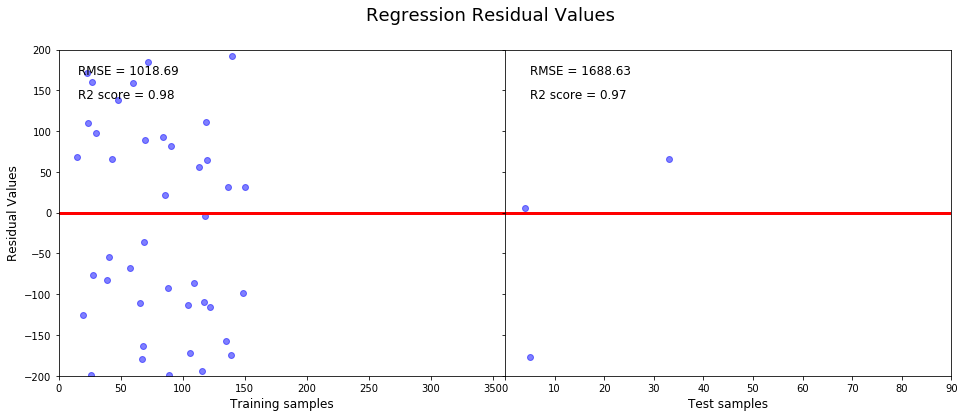

In [50]:
%matplotlib inline
from sklearn.metrics import mean_squared_error, r2_score

# Set up a multi-plot chart.
f, (a0, a1) = plt.subplots(1, 2, gridspec_kw = {'width_ratios':[1, 1], 'wspace':0, 'hspace': 0})
f.suptitle('Regression Residual Values', fontsize = 18)
f.set_figheight(6)
f.set_figwidth(16)

# Plot residual values of training set.
a0.axis([0, 360, -200, 200])
a0.plot(y_residual_train, 'bo', alpha = 0.5)
a0.plot([-10,360],[0,0], 'r-', lw = 3)
a0.text(16,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_train, y_pred_train))), fontsize = 12)
a0.text(16,140,'R2 score = {0:.2f}'.format(r2_score(y_train, y_pred_train)), fontsize = 12)
a0.set_xlabel('Training samples', fontsize = 12)
a0.set_ylabel('Residual Values', fontsize = 12)

# Plot a histogram.
#a0.hist(y_residual_train, orientation = 'horizontal', color = ['b']*len(y_residual_train), bins = 10, histtype = 'step')
#a0.hist(y_residual_train, orientation = 'horizontal', color = ['b']*len(y_residual_train), alpha = 0.2, bins = 10)

# Plot residual values of test set.
a1.axis([0, 90, -200, 200])
a1.plot(y_residual_test, 'bo', alpha = 0.5)
a1.plot([-10,360],[0,0], 'r-', lw = 3)
a1.text(5,170,'RMSE = {0:.2f}'.format(np.sqrt(mean_squared_error(y_test, y_pred_test))), fontsize = 12)
a1.text(5,140,'R2 score = {0:.2f}'.format(r2_score(y_test, y_pred_test)), fontsize = 12)
a1.set_xlabel('Test samples', fontsize = 12)
a1.set_yticklabels([])

# Plot a histogram.
#a1.hist(y_residual_test, orientation = 'horizontal', color = ['b']*len(y_residual_test), bins = 10, histtype = 'step')
#a1.hist(y_residual_test, orientation = 'horizontal', color = ['b']*len(y_residual_test), alpha = 0.2, bins = 10)

plt.show()

### Calculate metrics for the prediction

Now visualize the data on a scatter plot to show what our truth (actual) values are compared to the predicted values 
from the trained model that was returned.

<IPython.core.display.Javascript object>


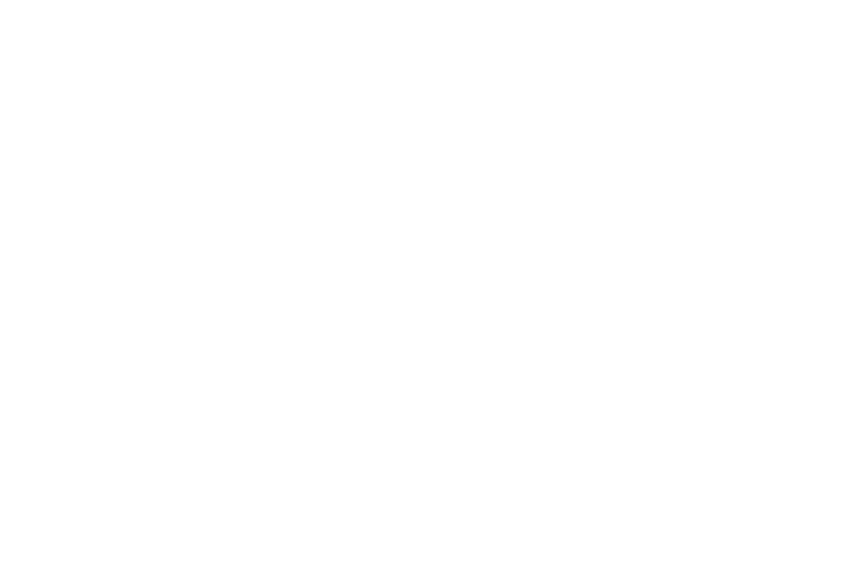

<IPython.core.display.Javascript object>


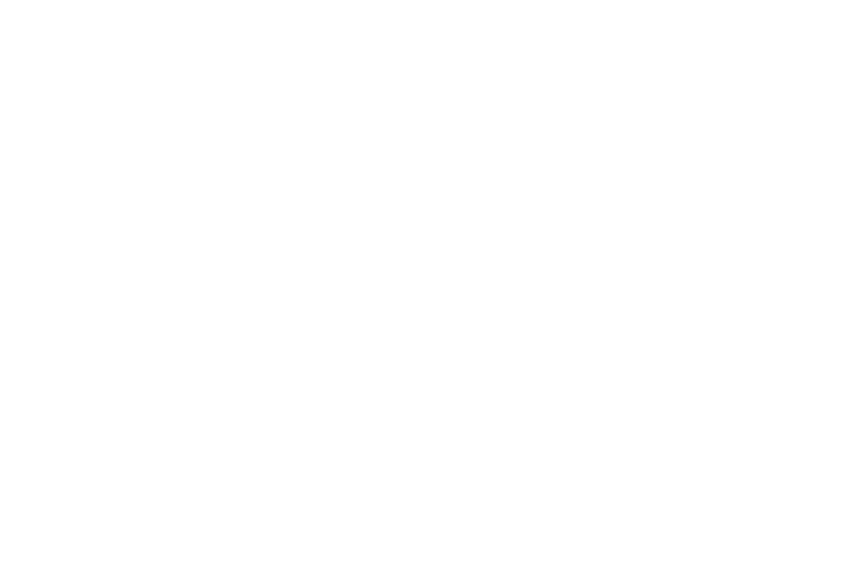

In [51]:
# Plot outputs
%matplotlib notebook
test_pred = plt.scatter(y_test, y_pred_test, color='b')
test_test = plt.scatter(y_test, y_test, color='g')
plt.legend((test_pred, test_test), ('prediction', 'truth'), loc='upper left', fontsize=8)
plt.show()